In [1]:
import selfies as sf
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import torch
import torch.nn as nn
import random, glob, os
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../smiles_selfies_full.csv')

### Tokenization

In [165]:
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def tokens_to_ids(tokens, tok2id):
    return np.array([tok2id[t] for t in tokens])

df['token_ids'] = df['tokens'].apply(lambda toks: tokens_to_ids(toks, tok2id))
df['lenghts'] = df['token_ids'].apply(len)

### Data prep

In [161]:
sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.zeros((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(data, test_size=0.5, random_state=42, shuffle=True)
print(max_len)

75


### Model

In [49]:
class BaselineVAE(nn.Module):
    def __init__(self, vocab_size, max_len, embed_size=64, hidden_size=128, latent_size=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.start_T = 5
        self.max_len = max_len

        self.encoder = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=5, padding=2, dilation=1),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=4, dilation=2),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=8, dilation=4),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=16, dilation=8),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=32, dilation=8),
            nn.ReLU(),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        self.fc_z = nn.Linear(latent_size, hidden_size * self.start_T)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 7, stride=1, padding=6)
        )        
        self.output_fc = nn.Linear(hidden_size, vocab_size)

    def encode(self, x):
        h = self.embed(x).transpose(1,2)
        h = self.encoder(h)
        h = self.pool(h).squeeze(-1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        # mu = h[:, :self.latent_size]
        # logvar = h[:, self.latent_size:]
        return mu, logvar
    
    def decode(self, z):
        B = z.size(0)
        h = self.fc_z(z)
        h = h.view(B, self.hidden_size, self.start_T)
        h = self.decoder(h)            # [B, H, T]
        #h = h[:, :, :self.max_len]     # ensure exact T
        #logits = h.transpose(1,2)      # [B, T, vocab_size]   
        logits = self.output_fc(h.transpose(1, 2))  # [B, T, vocab]
        return logits
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        logits = self.decode(z)
        return logits, mu, logvar
    
    def encode_sequence(self, x, batch_size=256):
        self.eval()
        device = next(self.parameters()).device
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.long)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        loader = DataLoader(TensorDataset(x), batch_size=batch_size)
        logits_list, mu_list, logvar_list = [], [], []
        with torch.no_grad():
            for (bx,) in loader:
                bx = bx.to(device)
                logits, mu, logvar = self(bx)
                #logits_list.append(logits.cpu())
                mu_list.append(mu.cpu())
                logvar_list.append(logvar.cpu())
        #logits = torch.cat(logits_list, dim=0)
        mu = torch.cat(mu_list, dim=0)
        logvar = torch.cat(logvar_list, dim=0)
        return logits, mu, logvar
    
def vae_loss(logits, x, mu, logvar, beta=0.1, pad_id=0):
    B, T, V = logits.shape
    logits_flat = logits.reshape((B*T, V))
    targets_flat = x[:, :T].reshape(B*T)

    mask = (targets_flat != pad_id)
    valid_logits = logits_flat[mask]
    valid_targets = targets_flat[mask]
    
    rec_loss = F.cross_entropy(valid_logits, valid_targets)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = rec_loss + beta * kl_loss
    return loss, rec_loss, kl_loss

### Training

In [190]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = BaselineVAE(vocab_size=len(vocab), max_len=train_data.shape[-1]).to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# epochs = 50
# beta = 0.01
# batch_size = 512

# train_loader = DataLoader(train_data, batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size, shuffle=True)
# history = []

for epoch in range(1, epochs + 1):
    model.train()
    total_recon = 0
    total_kl = 0
    val_recon = 0
    val_kl = 0

    for x in train_loader:
        x = x.to(device)

        logits, mu, logvar = model(x)        
        loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_recon += rec.item()
        total_kl += kl.item()

    with torch.no_grad():
        for x in val_loader:
            x = x.to(device)
            logits, mu, logvar = model(x)
            loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)
            val_recon += rec.item()
            val_kl += kl.item()

    val_loss = val_recon + val_kl
    history.append(((total_recon+total_kl)/len(train_loader), total_recon / len(train_loader), total_kl / len(train_loader), val_loss/len(val_loader)))
    print(f"Epoch {epoch:03d} | total={(total_recon+total_kl)/len(train_loader):.4f} | recon={total_recon/len(train_loader):.4f} | KL={total_kl/len(train_loader):.4f} | val={val_loss/len(val_loader):.4f}")


Epoch 001 | total=1.5040 | recon=0.0243 | KL=1.4797 | val=1.5208
Epoch 002 | total=1.5271 | recon=0.0366 | KL=1.4905 | val=1.5291
Epoch 003 | total=1.4968 | recon=0.0232 | KL=1.4736 | val=1.4798
Epoch 004 | total=1.5002 | recon=0.0251 | KL=1.4751 | val=1.4986
Epoch 005 | total=1.5059 | recon=0.0279 | KL=1.4780 | val=1.4459
Epoch 006 | total=1.5142 | recon=0.0303 | KL=1.4839 | val=1.4640
Epoch 007 | total=1.4893 | recon=0.0212 | KL=1.4680 | val=1.5270
Epoch 008 | total=1.4910 | recon=0.0240 | KL=1.4670 | val=1.4660
Epoch 009 | total=1.5011 | recon=0.0264 | KL=1.4746 | val=1.6808
Epoch 010 | total=1.4968 | recon=0.0265 | KL=1.4702 | val=1.4685
Epoch 011 | total=1.4692 | recon=0.0198 | KL=1.4494 | val=1.5218
Epoch 012 | total=1.4793 | recon=0.0235 | KL=1.4558 | val=1.4571
Epoch 013 | total=1.4973 | recon=0.0311 | KL=1.4663 | val=1.4161
Epoch 014 | total=1.5143 | recon=0.0316 | KL=1.4827 | val=1.4858
Epoch 015 | total=1.4666 | recon=0.0203 | KL=1.4463 | val=1.4189
Epoch 016 | total=1.4767 

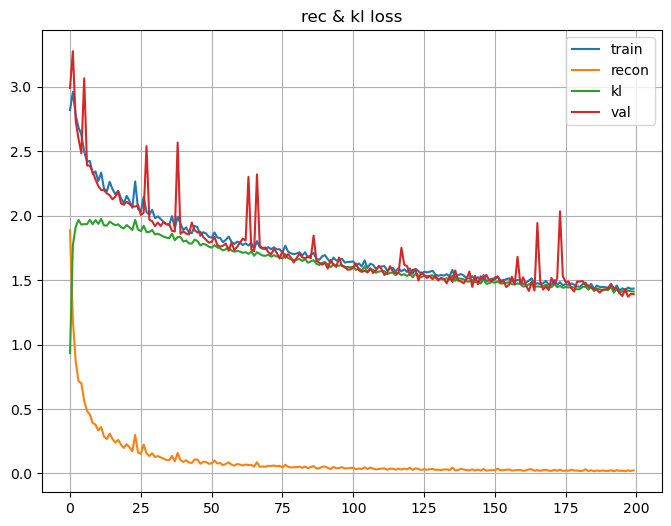

In [191]:
plt.figure(figsize=(8,6))
plt.plot(np.array(history)[:, 0], label='train')
plt.plot(np.array(history)[:, 1], label='recon')
plt.plot(np.array(history)[:, 2], label='kl')
plt.plot(np.array(history)[:, 3], label='val')
plt.title('rec & kl loss')
plt.legend()
plt.grid()
plt.show()

In [218]:
ckpt = {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "history": history,"vocab_size": len(vocab)}
torch.save(ckpt, "trained_models/tcn_vae_baseline.pt")

In [193]:
logits, mu, logvar = model.encode_sequence(val_data)
z = mu
z = z.cpu().numpy()

### Visualization 

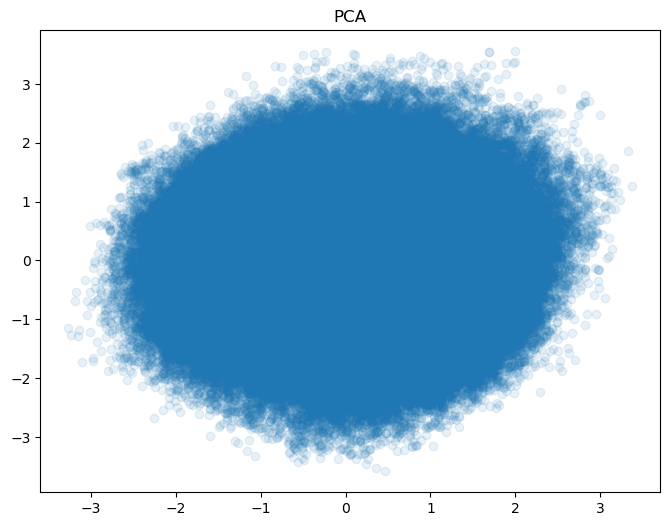

In [201]:
pca_z = PCA(n_components=2).fit_transform(z)
plt.figure(figsize=(8,6))
plt.scatter(pca_z[:, 0], pca_z[:, 1], alpha=0.1)
plt.title('PCA')
plt.show()

### Testing latent

In [202]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

In [203]:
x = val_data[0:1]
print(x.shape)
logits, mu, logvar = model.encode_sequence(x)
print(logits.shape)
tokens = torch.argmax(logits, dim=-1)
print(tokens_to_selfie(x[0]))
print(tokens_to_selfie(tokens[0]))

(1, 75)
torch.Size([1, 74, 110])
['[C]', '[C]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[#Branch1]', '[C@@]', '[C]', '[C]', '[C@@H1]', '[Branch1]', '[Ring2]', '[C]', '[Ring1]', '[Branch1]', '[O]', '[C]', '[Ring1]', '[#Branch1]', '[=O]', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['[C]', '[C]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[#Branch1]', '[C@@]', '[C]', '[C]', '[C@@H1]', '[Branch1]', '[Ring2]', '[C]', '[Ring1]', '[Branch1]', '[C]', '[C]', '[Ring1]', '[#Branch1]', '[=O]', '[=O]', '[=O]', '[=O]', '[=O]', '[#Branch1]'

In [204]:
def get_accuracy_samples(model, data, pad_id=0, num_samples=5):
    model.eval()    
    for _ in range(num_samples):
        i = np.random.randint(0, len(data))
        x = data[i]
        x = x[np.newaxis, :]
        logits, mu, logvar = model.encode_sequence(x)
        x_rec = torch.argmax(logits, dim=-1)
        acc, pad = 0, 0
        j = 0
        x = x.squeeze(0)
        x_rec = x_rec.squeeze(0)
        while x[j] != pad_id:
            pad += 1
            if x[j] == x_rec[j]:
                acc += 1
            j+=1
        acc = acc / pad
        print(f"real: {tokens_to_selfie(x)}")
        print(f"rec: {tokens_to_selfie(x_rec)}")
        print(f"accuracy: {acc}")
        print('------------------------------')

In [205]:
get_accuracy_samples(model, test_data, pad_id=0, num_samples=5)

real: ['[C]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[C]', '[C]', '[C]', '[C]', '[Ring1]', '[Branch1]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[Ring1]', '[=Branch2]', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
rec: ['[C]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[C]', '[C]', '[C]', '[C]', '[Ring1]', '[Branch1]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[Ring1]', '[=Branch2]', '[=O]', '[=O]', '[=O]', '[#Branch1]', '[Branch2]', '[C]', '[Ring2]', '[Branch2]', '[Ring1]', '[C]', '[=N]', '[=O]', 

In [206]:
def get_accuracy(model, data, pad_id=0, batch_size=64):
    model.eval()
    all_accs = []
    perfect = 0
    with torch.no_grad():
        for b in range(0, len(data), batch_size):
            batch = data[b : b + batch_size, :-1]              
            batch = torch.tensor(batch, device='cuda')  
            logits, mu, logvar = model.encode_sequence(batch)   
            preds = torch.argmax(logits, dim=-1)                
            mask = (batch != pad_id)                            
            correct = (batch == preds) & mask                   
            acc = correct.sum(dim=1).float() / mask.sum(dim=1)
            all_accs.extend(acc.cpu().tolist())
            perfect += (acc == 1).sum().item()
    print(f"reconstructed correctly {perfect} out of {len(data)} molecules")
    print(f"correct rec %: {perfect*100 / len(data):.2f}%")
    print(f"mean accuracy: {np.mean(all_accs)*100:.2f}%")

In [207]:
get_accuracy(model, test_data)

reconstructed correctly 206337 out of 397202 molecules
correct rec %: 51.95%
mean accuracy: 95.44%


### Visualisations

In [208]:
logits, mu, logvar = model.encode_sequence(data)
z = mu
z.cpu().numpy()

In [228]:
n_samples = 5000
idxs = np.random.choice(z.shape[0], size=n_samples, replace=False)
z_sample = z[idxs]
len_labels = len_labels = np.array(df['lenghts'])[idxs]
z_sample.shape

torch.Size([5000, 64])

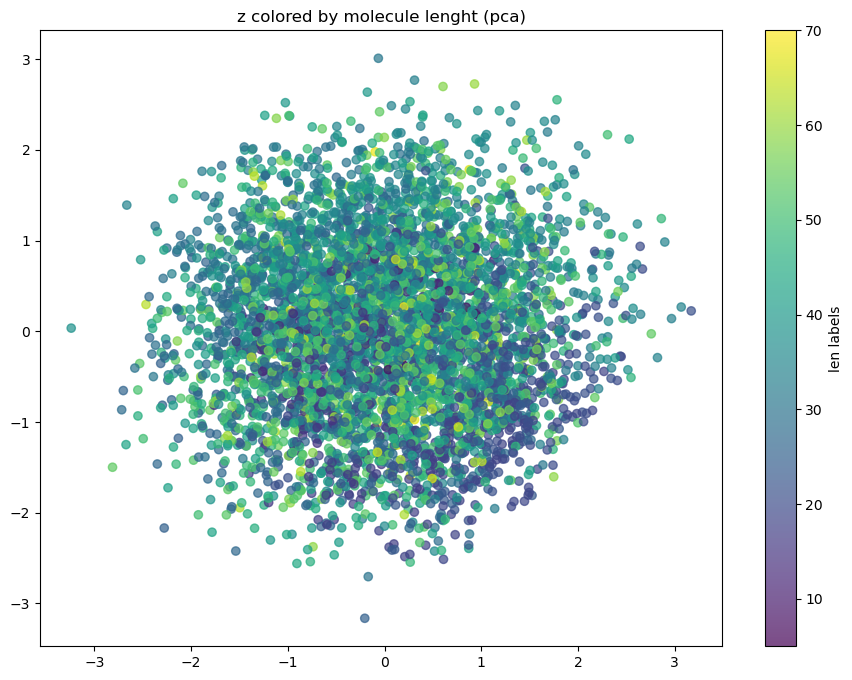

In [242]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (pca)')
plt.colorbar(label='len labels')
plt.show()

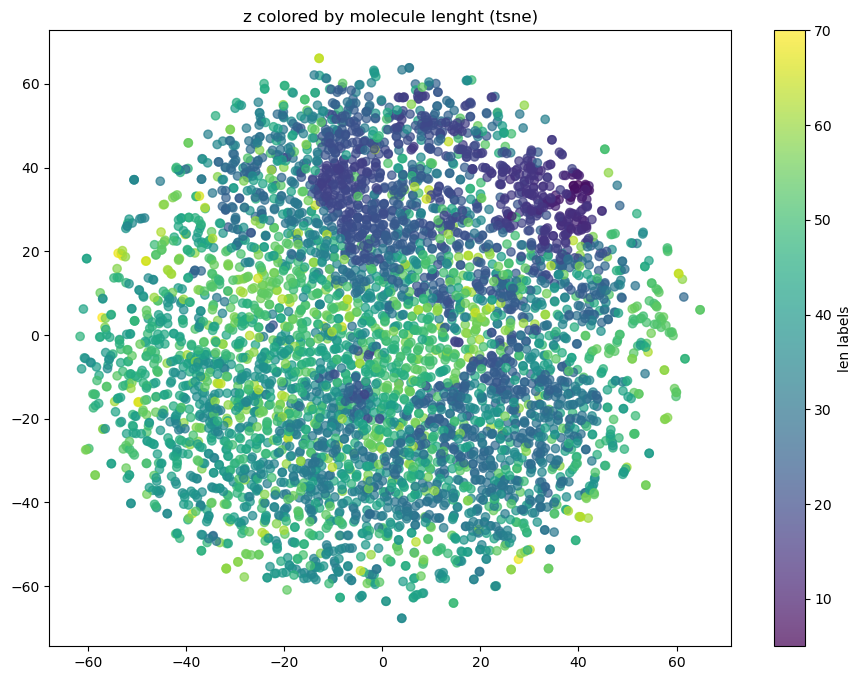

In [241]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (tsne)')
plt.colorbar(label='len labels')
plt.show()

In [248]:
oxygen_labels = df['selfies'].apply(lambda x: 1 if 'O' in x else 0)[idxs]

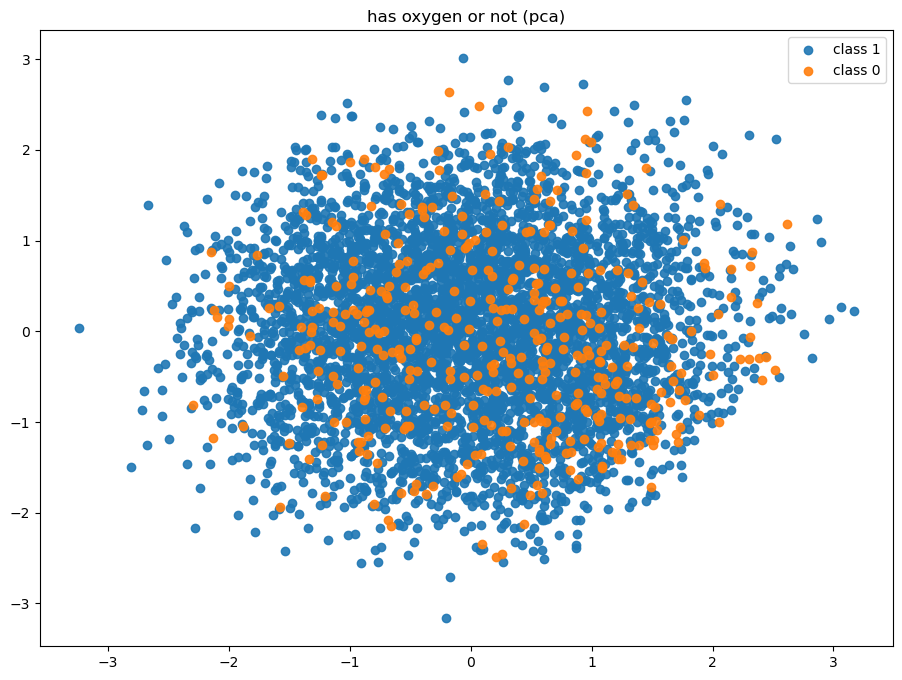

In [249]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

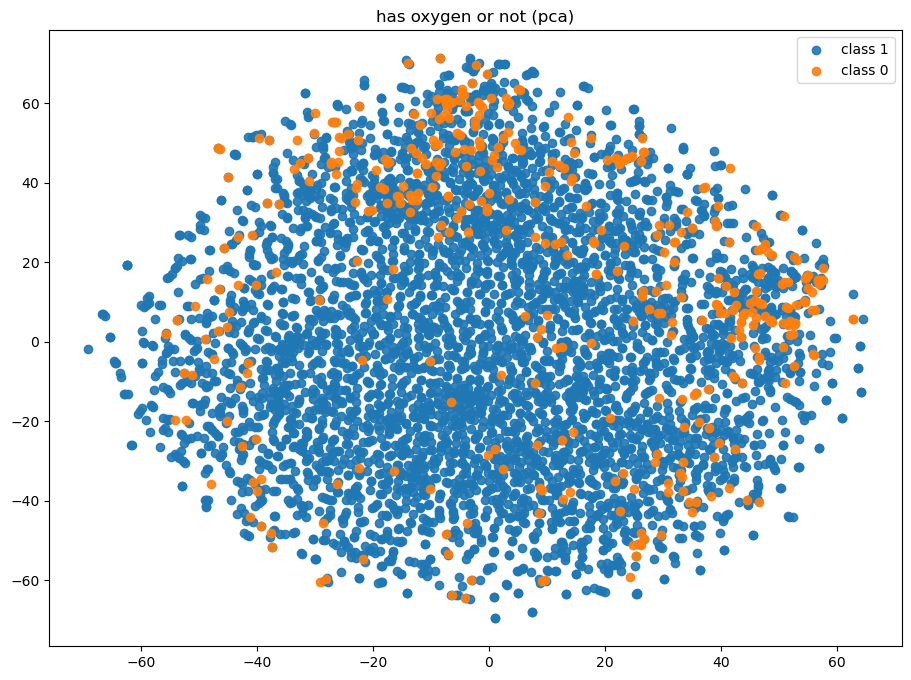

In [250]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

In [259]:
carbon_label =  df['selfies'].apply(lambda x: x.count('C'))[idxs]

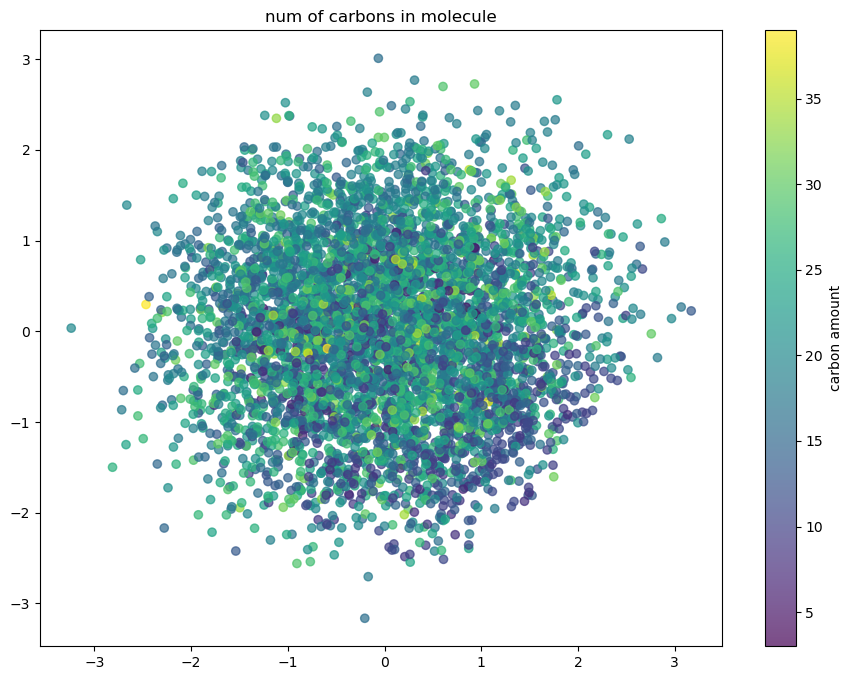

In [262]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule')
plt.colorbar(label='carbon amount')
plt.show()

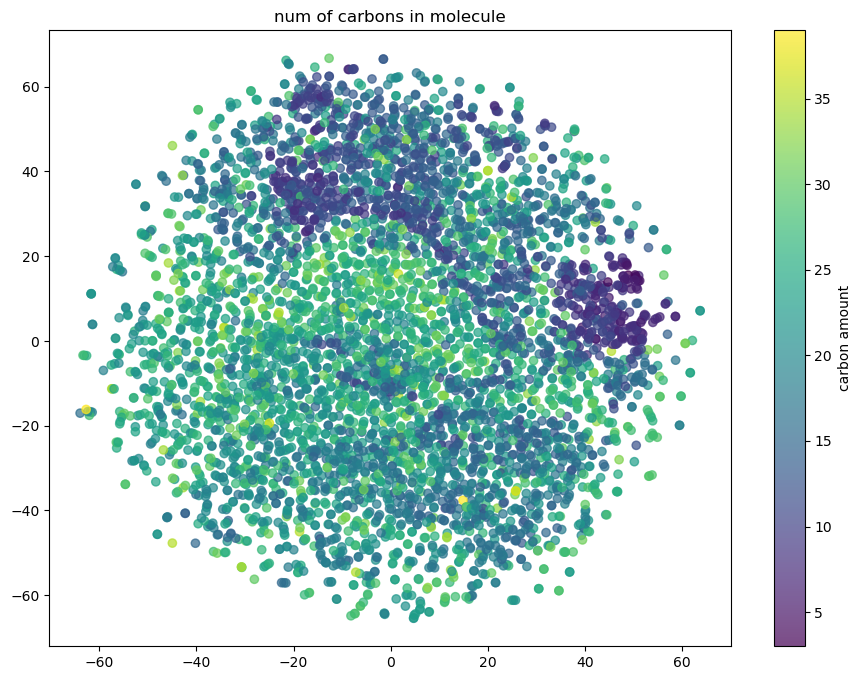

In [263]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule')
plt.colorbar(label='carbon amount')
plt.show()